# 1. 准备

In [1]:
# 设置可见的GPU 为 3 和4
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2, 3, 4"
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [2]:
# 导入必备的包

import torch.nn.functional as F

from PIL import Image
from matplotlib.pyplot import imshow

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path, select_best_resolution

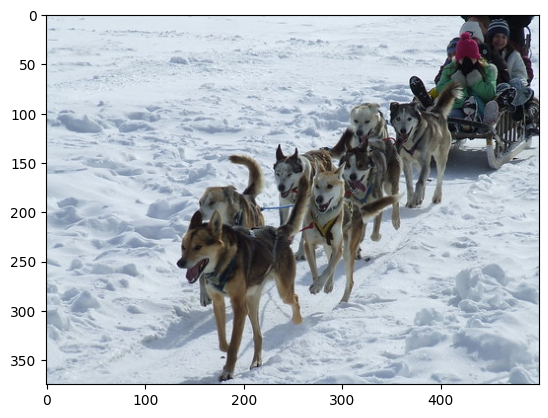

In [3]:
# 模型、测试样例设置

model_path = '/home/kaiyu/Model/liuhaotian/llava-v1.6-vicuna-7b/'
model_base = None
question = 'Is there a dog in the image?\\nAnswer the question using a single word or phrase.'
# question = 'describe the image'
image_file = "./sample/dogsled.jpg"
# image_file = "./sample/tigercat.jpg"
conv_mode = 'vicuna_v1'
temperature = 0
top_p = None
num_beams = 1

# from ImageNet
image = Image.open(image_file).convert('RGB')
# image = Image.open('./sample/dogsled.jpg')
imshow(image)

In [4]:
# 加载模型
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*copying from a non-meta parameter.*")

# Model
disable_torch_init()
model_path = os.path.expanduser(model_path)
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/home/kaiyu/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/home/kaiyu/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# input 处理

qs = question
cur_prompt = qs
if model.config.mm_use_im_start_end:
    qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
else:
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

image_tensor = process_images([image], image_processor, model.config)[0]


# 2. 推理

In [6]:
# 推理

model.train()

image_tensor = image_tensor.unsqueeze(0).half().cuda()
image_tensor.requires_grad_()

output = model(
    input_ids=input_ids,
    use_cache=True,
    images=image_tensor,
    image_sizes=[image.size],
    output_attentions=True,
)

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


# 3. 计算 CAM

In [7]:
# 步骤1：获取注意力分数并激活梯度跟踪
attentions = output.attentions  # 假设out是模型的输出，并且包含注意力权重
for attn_layer in attentions:
    attn_layer.retain_grad()  # 保留非叶张量的梯度

In [8]:
# 步骤2：选择预测输出并执行反向传播
prediction = output.logits
label_index = prediction.argmax(dim=-1)  # 获取输出索引，这里假设是argmax作为预测类别
prediction_score = prediction[:, -1, label_index[0][-1]]  # 获取对应的得分

prediction_score.backward()  # 对得分进行反向传播，生成梯度

In [9]:
# 步骤3：获取梯度并与注意力分数相乘
# 注意力权重和梯度的shape可能是[num_layers, batch_size, num_heads, seq_length, seq_length]
# 而我们只对最后一个token的注意力分数乘梯度感兴趣。
gradient = [attn_layer.grad for attn_layer in attentions]  # 获取所有层的梯度

modified_attention = []
for attn_layer, grad_layer in zip(attentions, gradient):
    if(grad_layer is None):
        continue
    # 广播后点乘的shape可能是 [batch_size, num_heads, seq_length, seq_length]
    grad_weighted_attn = grad_layer * attn_layer
    # 可能需要进一步的处理，如取平均值等
    grad_weighted_attn = grad_weighted_attn.mean(dim=1)  # 假设我们合并头部的注意力
    # 对每一个元素取 relu
    grad_weighted_attn = F.relu(grad_weighted_attn)
    modified_attention.append(grad_weighted_attn)
    
# 这里的modified_attention是一个包含所有处理后层的列表，每层包含经过梯度加权的注意力分数

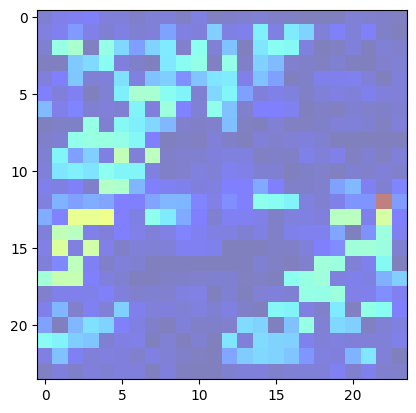

In [10]:
# 步骤4：可视化 base_image_feature

# 获取对应的 CAM 分数

layer_num = 0
visual_cam = modified_attention[layer_num][0][-1, 35:611]

# visial_cam 转为 24 * 24 的矩阵
visual_cam = visual_cam.reshape(24, 24).cpu().detach().float()

imshow(visual_cam, alpha=0.5, cmap='jet')

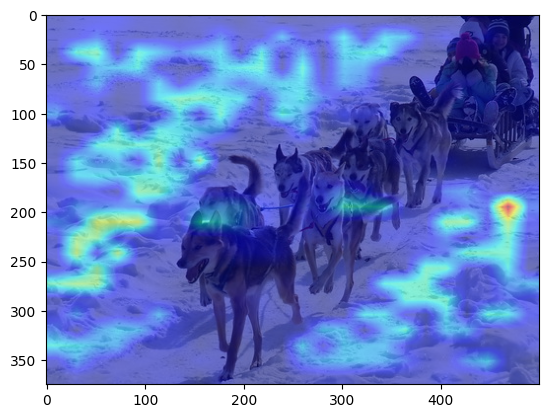

In [11]:
# 对 CAM 分数进行拉伸差值
H, W = image.size
cam = F.interpolate(visual_cam.unsqueeze(0).unsqueeze(0), size=(W, H), mode='bilinear', align_corners=False).squeeze()

# 显示原始图像
imshow(image)

# 叠加热力图
imshow(cam, alpha=0.5, cmap='jet')

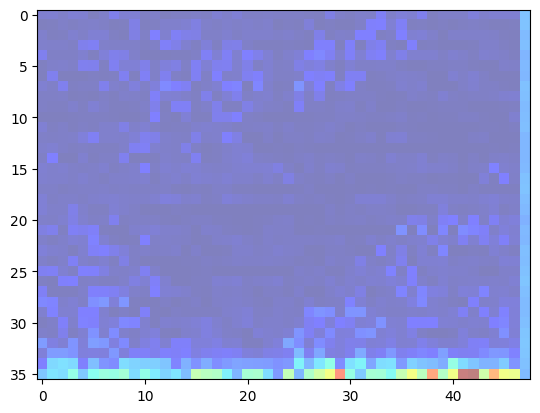

In [12]:
# 步骤4：可视化 划分为 4 块的 image_feature

# 计算对应块的索引

best_resolution = select_best_resolution(image.size, model.config.image_grid_pinpoints)

# 分别对宽度和高度进行除法操作
width_ratio = best_resolution[0] / image.size[0]
height_ratio = best_resolution[1] / image.size[1]

if width_ratio <= height_ratio:
    W_reshape = best_resolution[1]/14 
    H_reshape = image.size[1]*width_ratio/14
else:
    W_reshape = image.size[0]*height_ratio/14 
    H_reshape = best_resolution[0]/14

# 对 H_reshape 和 W_reshape 取整
H_reshape = int(H_reshape)
W_reshape = int(W_reshape) + 1

# 获取对应的 CAM 分数

visual_cam = modified_attention[layer_num][0][-1, 612:612+H_reshape*W_reshape]

# visial_cam 转为 24 * 24 的矩阵
visual_cam = visual_cam.reshape(H_reshape, W_reshape).cpu().detach().float()[:, :W_reshape-1]

imshow(visual_cam, alpha=0.5, cmap='jet')

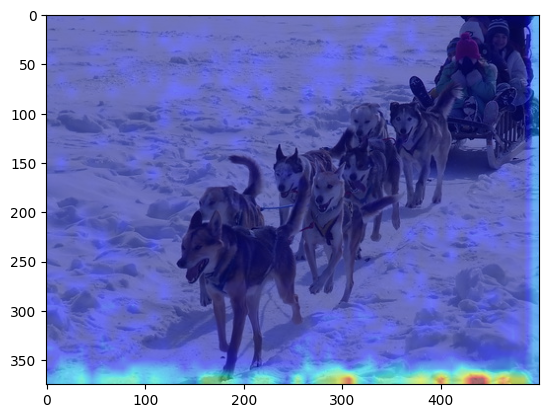

In [13]:
# 对 CAM 分数进行拉伸差值
H, W = image.size
cam = F.interpolate(visual_cam.unsqueeze(0).unsqueeze(0), size=(W, H), mode='bilinear', align_corners=False).squeeze()

# 显示原始图像
imshow(image)

# 叠加热力图
imshow(cam, alpha=0.5, cmap='jet')